In [ ]:
Pkg.update()
Pkg.add("Jacobi")
Pkg.add("FastGaussQuadrature")
Pkg.add("PyPlot")

In [3]:
using FastGaussQuadrature
using Jacobi

nodePoints=200 # Number of quadrature nodes used to compute L matrix.

function b_n(n::Int64)
    numerator = -n*(n+1)
    denominator = (n+2)*(n+3)
    return numerator/denominator
end

function M_ij(size::Int64)
    fullMatrix = zeros(size,size)
    for i=0:size-1
        for j=0:size-1
            if i==j
                fullMatrix[i+1, j+1] = 2/(2*i+1) + (b_n(i)*b_n(i))*(2/(2*i+5))
            elseif i==j+2
                fullMatrix[i+1, j+1] = b_n(j)*(2/(2*j+5))
            elseif i==j-2
                fullMatrix[i+1, j+1] = b_n(i)*(2/(2*j+1))
            end
        end
    end
    return fullMatrix/2
end

function B_ij(size::Int64)
    fullMatrix = zeros(size,size)
    for i=0:size-1
        for j=0:size-1
            if i==j
                fullMatrix[i+1,j+1]=2/(2*i+1)
            elseif i==j-2
                fullMatrix[i+1,j+1]=b_n(i)*2/(2*i+5)
            end
        end
    end
    return fullMatrix/2
end

function L_ij(size::Int64, S::Function)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=i:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                dp_i = 2.*(djacobi(values[k+1],i,0,0)+b_n(i)*djacobi(values[k+1],i+2,0,0))
                dp_j = 2.*(djacobi(values[k+1],j,0,0)+b_n(j)*djacobi(values[k+1],j+2,0,0))
                newPiece = weights[k+1]*S((values[k+1]+1.)/2.)*dp_i*dp_j
                sumTotal = sumTotal + newPiece
            end
            fullArray[i+1,j+1] = .5*sumTotal
            fullArray[j+1,i+1] = .5*sumTotal
        end
    end
    return fullArray
end

function galerkin_p_psi_print(size::Int64, coefficients, value)
    sumTotal = 0
    for i=size-1:-1:0
        p = jacobi(2.*value -1., i, 0,0)+b_n(i)*jacobi(2.*value -1.,i+2,0,0)
        sumTotal = sumTotal + coefficients[i+1]*p
    end
    return sumTotal
end
;


Use "local i; local k; local iter=0" instead.

Use "abstract type QUADRATURE_TYPE end" instead.


# Linear Stability

In [265]:
function dq_galerkin_coefficients(size::Int64, dq_bar::Function)
    fullArray = zeros(size)
    values, weights = gausslegendre(nodePoints)
    for i =0:size-1
        sumTotal = 0
        for k=0:nodePoints-1
            p_n = jacobi(values[k+1], i,0,0)
            sumTotal = sumTotal + weights[k+1]*p_n*dq_bar((values[k+1]+1.)/2.)
        end
        fullArray[i+1] = sumTotal*(2*i+1)/2
    end
    return fullArray
end

function dq_galerkin(size::Int64, coefficients, value::Float64)
    sumTotal = 0
    for i=0:size-1
        sumTotal = sumTotal + coefficients[i+1]*jacobi(2.*value-1.,i,0,0)
    end
    return sumTotal
end

function p_psi_function(size::Int64, value::Float64)
    fullArray = zeros(size)
    for i=0:size-1
        fullArray[i+1] = jacobi(2.*value-1.,i,0,0)+b_n(i)*jacobi(2.*value-1.,i+2,0,0)
    end
    return fullArray
end

function p_q_function(size::Int64, value::Float64) # We shouldn't need this function
    fullArray = zeros(size)
    for i=0:size-1
        fullArray[i+1] = jacobi(2.*value-1.,i,0,0)
    end
    return fullArray
end

function dy_vartheta_bar(S::Function, du_bar::Function, value::Float64)
    return -S(value)*du_bar(value)
end

function dy_psi(u_bar::Function, value::Float64)
    return -u_bar(value)
end

function dy_psi_galerkin(size::Int64, u_bar_coefficients, value::Float64)
    return -u_galerkin(size, u_bar_coefficients, value)
end

function u_galerkin_coefficients(size::Int64, dq_coefficients, dvt_plus, dvt_minus, first_u_coefficient, du_bar::Function, S::Function, LMatrix, BMatrix)
    r_piece1 = BMatrix*dq_coefficients
    r_piece2 = dvt_plus*p_psi_function(size,1.0)
    r_piece3 = dvt_minus*p_psi_function(size,0.0)
    rhs = r_piece1-r_piece2+r_piece3
    lhs = LMatrix[2:size,2:size]
    rhs = rhs[2:size]
    coefficients = lhs \ rhs
    return prepend!(coefficients,[first_u_coefficient])
end

function u_galerkin(size::Int64, coefficients, value)
    sumTotal = 0
    for i=0:size-1
        nextCoe = coefficients[i+1]
        sumTotal = sumTotal + coefficients[i+1]*(jacobi(2.*value -1., i, 0,0)+b_n(i)*jacobi(2.*value -1.,i+2,0,0))
    end
    return sumTotal
end

u_galerkin (generic function with 1 method)

In [5]:
function U_ij(size::Int64, u_galerkin_coefficients)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                p_psi = jacobi(values[k+1],i,0,0)+b_n(i)*jacobi(values[k+1],i+2,0,0)
                p_q = jacobi(values[k+1],j,0,0)
                u_galerk = u_galerkin(size, u_galerkin_coefficients, (values[k+1]+1.)/2.)
                sumTotal = sumTotal + weights[k+1]*p_psi*p_q*u_galerk
            end
            fullArray[i+1, j+1] = .5*sumTotal
        end
    end
    return fullArray
end

function Q_ij(size::Int64, dq_galerkin_coefficients)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=i:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                dq_galerk = dq_galerkin(size, dq_galerkin_coefficients, (values[k+1]+1.)/2.)
                p_psi_i = jacobi(values[k+1],i,0,0)+b_n(i)*jacobi(values[k+1],i+2,0,0)
                p_psi_j = jacobi(values[k+1],j,0,0)+b_n(j)*jacobi(values[k+1],j+2,0,0)
                sumTotal = sumTotal + weights[k+1]*dq_galerk*p_psi_i*p_psi_j
            end
            fullArray[i+1, j+1] = .5*sumTotal
            fullArray[j+1, i+1] = .5*sumTotal
        end
    end
    return fullArray
end

Q_ij (generic function with 1 method)

In [6]:
function psi(size, kx, ky, M_matrix, L_matrix, value)
    first_piece = (kx^2+ky^2)*M_matrix+L_matrix
    second_piece = p_psi_function(size, value)
    return first_piece \ second_piece
end

function computeMatricesForStabilityAnalysis(sizeOfMatrix, S_function, dq_function, du_function,dvt_plus, dvt_minus, first_coefficient)
    B = B_ij(sizeOfMatrix)
    L = L_ij(sizeOfMatrix, S_function)
    M = M_ij(sizeOfMatrix)
    dq_coefficients = dq_galerkin_coefficients(sizeOfMatrix, dq_function)
    u_coefficients = u_galerkin_coefficients(sizeOfMatrix, dq_coefficients, dvt_plus, dvt_minus, first_coefficient, du_function, S_function, L, B)

    U = U_ij(sizeOfMatrix, u_coefficients)
    Q = Q_ij(sizeOfMatrix, dq_coefficients)
    #println("Matrices Computed")
    return (B,L,M,U,Q, u_coefficients, dq_coefficients)
end

function getSimplifiedStabilityEigenObjectsOfKx(sizeOfMatrix, beta_value, ky, kxValues, S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    (B,L,M,U,Q,u_coefficients,dq_coefficients) = computeMatricesForStabilityAnalysis(sizeOfMatrix,S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    #Should have stable eigenvalues
    (values, vectors) = eig(U, B)
    if(minimum(imag(values))>0)
        println("Stable piece is unstable...")
    end
    
    eigenObjects = []
    for i=1:length(kxValues)
        kx = kxValues[i]
        ul = u_galerkin(sizeOfMatrix, u_coefficients, 1.)+dvt_plus*vecdot(p_psi_function(sizeOfMatrix, 1.),psi(sizeOfMatrix,kx,ky,M,L,1.))
        ur = -dvt_plus*vecdot(p_psi_function(sizeOfMatrix, 1.),psi(sizeOfMatrix,kx,ky,M,L,0.))
        ll = dvt_minus*vecdot(p_psi_function(sizeOfMatrix, 0.),psi(sizeOfMatrix,kx,ky,M,L,1.))
        lr = u_galerkin(sizeOfMatrix, u_coefficients, 0.)-dvt_minus*vecdot(p_psi_function(sizeOfMatrix, 0.),psi(sizeOfMatrix,kx,ky,M,L,0.))
        lhs = [[ul ur]; [ll lr]]
        eigenResult = eigfact(lhs)
        append!(eigenObjects, [eigenResult])
    end
    #println("Done computing eigenvalues and eigenvectors for all kx's")
    return eigenObjects
end

function getCompleteStabilityEigenObjectsOfKx(sizeOfMatrix, beta_value, ky, kxValues, S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    (B,L,M,U,Q,u_coefficients,dq_coefficients) = computeMatricesForStabilityAnalysis(sizeOfMatrix,S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    eigenObjects = []

    for i=1:length(kxValues)
        kx = kxValues[i]
        psi_plus = psi(sizeOfMatrix,kx,ky,M,L,1.)
        psi_minus = psi(sizeOfMatrix,kx,ky,M,L,0.)
        p_psi_plus = p_psi_function(sizeOfMatrix, 1.)
        p_psi_minus = p_psi_function(sizeOfMatrix, 0.)
        centerRowMatrix = ((kx^2+ky^2)*M+L)\B
        
        ul = u_galerkin(sizeOfMatrix, u_coefficients, 1.)+dvt_plus*vecdot(p_psi_plus,psi_plus)
        uc = -(dvt_plus)*(p_psi_plus'*centerRowMatrix)
        ur = -dvt_plus*vecdot(p_psi_plus, psi_minus)
        cl = (Q+beta_value*M)*psi_plus
        cc = U-(Q+beta_value*M)*centerRowMatrix
        cr = -(Q+beta_value*M)*psi_minus
        ll = dvt_minus*vecdot(p_psi_minus,psi_plus)
        lc = -(dvt_minus)*(p_psi_minus'*centerRowMatrix)
        lr = u_galerkin(sizeOfMatrix, u_coefficients, 0.)-dvt_minus*vecdot(p_psi_minus,psi_minus)
        lhs = [[ul uc ur];[cl cc cr];[ll lc lr]]
        lhs_small = [[ul ur]; [ll lr]]
        
        rhs = [[1 zeros(1,sizeOfMatrix) 0];[zeros(sizeOfMatrix,1) B zeros(sizeOfMatrix,1)]; [0 zeros(1,sizeOfMatrix) 1]]
        eigenResult = eigfact(lhs, rhs)
        append!(eigenObjects, [eigenResult])
    end
    #println("Done computing eigenvalues and eigenvectors for all kx's")
    return eigenObjects
end
    
function getStabilityValues(eigenObjectsArray, kxValues)
    steps = length(kxValues)
    growthRates = zeros(steps)
    waveSpeeds = zeros(steps)
    minWaveSpeeds = zeros(steps)
    eigenvectors = []
    
    for i=1:steps
        kx = kxValues[i]
        max_im, max_ind = findmax(imag(eigenObjectsArray[i][:values]))
        append!(eigenvectors, [eigenObjectsArray[i][:vectors][:,max_ind]])
        waveSpeeds[i] = real(eigenObjectsArray[i][:values][max_ind])
        minWaveSpeeds[i] = minimum(real(eigenObjectsArray[i][:values]))
        growthRates[i] = max_im*kx
    end
    
    return growthRates, eigenvectors, waveSpeeds, minWaveSpeeds
end

function createFourStabilityPlots(sizeOfMatrix, S_function, growthRates, eigenvectors, waveSpeeds, minWaveSpeeds, kx_values, ky_value)
    B = B_ij(sizeOfMatrix)
    L = L_ij(sizeOfMatrix, S_function)
    M = M_ij(sizeOfMatrix)
    
    maxIndex = indmax(growthRates)
    maxKx = kx_values[maxIndex]
    #println("Max growth rate at kx=$maxKx")

    highVector = eigenvectors[maxIndex]
    vectorSize = length(highVector)
    highVector_bottom = highVector[vectorSize] 
    psi_coeffs = highVector[1]*psi(sizeOfMatrix, maxKx, ky_value, M, L, 1.)-highVector_bottom*psi(sizeOfMatrix,maxKx,ky_value, M,L,0.)
    psi_coeffs = psi_coeffs - ( (maxKx^2 + ky_value^2)*M + L ) \ B*highVector[2:end-1]
    
    heights = linspace(0,1,100)
    psi_angles = zeros(length(heights))
    psi_amps = zeros(length(heights))
    for i=1:length(heights)
        psi_val = galerkin_p_psi_print(sizeOfMatrix, psi_coeffs, heights[i])
        psi_angles[i] = angle(psi_val)
        psi_amps[i] = abs(psi_val)
    end

    #print(kxs[25])
    fig, axes = subplots(2,2)
    ax = axes[1,1]
    ax[:plot](kx_values, growthRates, label="N = $matrixSize")
    ax[:legend](loc="upper right")
    ax = axes[2,1]
    ax[:plot](kx_values, w_speeds, "b-")
    #ax[:plot](kx_values, w_minSpeeds, "b-")
    
    ax = axes[1,2]
    ax[:plot](psi_angles - psi_angles[1], heights)

    ax = axes[2,2]
    ax[:plot](psi_amps/maximum(psi_amps), heights)
end

createFourStabilityPlots (generic function with 1 method)

# Eady Problem

In [34]:
function z_linear(value::Float64)
    return value
end

function dz(value::Float64)
    return 1
end 

function dq(value::Float64)
    return 0
end

function S_constant(value::Float64)
    return 1.
end

S_constant (generic function with 1 method)

In [184]:
using PyPlot

#Analytic Solution
function c(kxValue::Float64)
    inner = (kxValue/2-coth(kxValue/2))*(kxValue/2-tanh(kxValue/2))
    c_value = 1/2 + 1/kxValue*((Complex(inner))^(1/2))
    return c_value
end

function AB(kxValue::Float64)
    c_value = c(kxValue)
    matrix = [ 1 kxValue*c_value; (c_value-1)*kxValue*sinh(kxValue)+1*cosh(kxValue) (c_value-1)*kxValue*cosh(kxValue)+1*sinh(kxValue)]
    solutions = nullspace(matrix)
    return solutions
end

function waveFunction(kxValue::Float64, zHeight)
    ABVal = AB(kxValue)
    waveReturn = ABVal[1]*cosh(kxValue*zHeight)+ABVal[2]*sinh(kxValue*zHeight)
    return waveReturn
end

function createFourStabilityPlotsCompareToExact(sizeOfMatrix, S_function, growthRates, eigenvectors, waveSpeeds, kx_values, ky_value)
    B = B_ij(sizeOfMatrix)
    L = L_ij(sizeOfMatrix, S_function)
    M = M_ij(sizeOfMatrix)
    
    maxIndex = indmax(growthRates)
    maxKx = kx_values[maxIndex]
    highVector = eigenvectors[maxIndex]
    vectorSize = length(highVector)
    highVector_bottom = highVector[vectorSize] 
    psi_coeffs = highVector[1]*psi(sizeOfMatrix, maxKx, ky_value, M, L, 1.)-highVector_bottom*psi(sizeOfMatrix,maxKx,ky_value, M,L,0.)
    psi_coeffs = psi_coeffs - ( (maxKx^2 + ky_value^2)*M + L ) \ B*highVector[2:end-1]
    
    heights = linspace(0,1,100)
    psi_angles = zeros(length(heights))
    psi_amps = zeros(length(heights))
    psi_angles_exact = zeros(length(heights))
    psi_amps_exact = zeros(length(heights))
    for i=1:length(heights)
        psi_val = galerkin_p_psi_print(sizeOfMatrix, psi_coeffs, heights[i])
        psi_angles[i] = angle(psi_val)
        psi_amps[i] = abs(psi_val)
        
        psiValueExact = waveFunction(1.61, heights[i])
        psi_angles_exact[i]= angle(psiValueExact)
        psi_amps_exact[i] = abs(psiValueExact)
    end

    #Exact Growth Rates and wave speeds
    growthRates_exact = zeros(length(kx_values))
    w_speeds_exact = zeros(length(kx_values))
    for i =1:length(kx_values)
        c_value = c(kx_values[i])
        growthRates_exact[i] = kx_values[i]*imag(c_value)
        w_speeds_exact[i] = real(c_value)
    end
    
    plot(psi_amps/maximum(psi_amps), heights, label="Galerkin")
    plot(psi_amps_exact/maximum(psi_amps_exact), heights, label="Exact")
    legend(loc="center right")
    xlabel("Amplitude")
    ylabel("Height")
    savefig("EadyAmplitude.eps", format="eps", dpi=1000)
    
end

createFourStabilityPlotsCompareToExact (generic function with 1 method)

In [179]:
 plot(kx_values, growthRates, label="Galerkin")
    plot(kx_values, growthRates_exact, label="Exact")
    legend(loc="upper right")
    xlabel("Zonal Wavenumber")
    ylabel("Growth Rate")
    savefig("EadyGrowthRates.eps", format="eps", dpi=1000)

plot(kx_values, w_speeds, label="Galerkin")
    plot(kx_values, w_speeds_exact, label="Exact")
    ylim(0,1)
    legend(loc="lower right")
    xlabel("Zonal Wavenumber")
    ylabel("Wave Speeds")
    savefig("EadyWaveSpeeds.eps", format="eps", dpi=1000)

plot(psi_angles - psi_angles[1], heights, label="Galerkin")
    plot(psi_angles_exact - psi_angles_exact[1], heights, label="Exact")
    legend(loc="upper left")
    xlabel("Phase")
    ylabel("Height")
    savefig("EadyPhase.eps", format="eps", dpi=1000)
    


LoadError: [91mUndefVarError: kx_values not defined[39m

In [ ]:
#Testing galerkin u
#=
first_coefficient = 0.5
matrixSize = 15
B = B_ij(matrixSize)
L = L_ij(matrixSize, S_constant)
M = M_ij(matrixSize)

dqc = dq_galerkin_coefficients(matrixSize, dq)
ugc = u_galerkin_coefficients(matrixSize, dqc,dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient, dz, S_constant, L, B)

#Test method
u_galerkin(matrixSize, ugc, .1)
#U_ij(matixSize, ugc)

#dq_galerkin(matrixSize, dqc, .3)
#Q_ij(matrixSize, dqc)=#

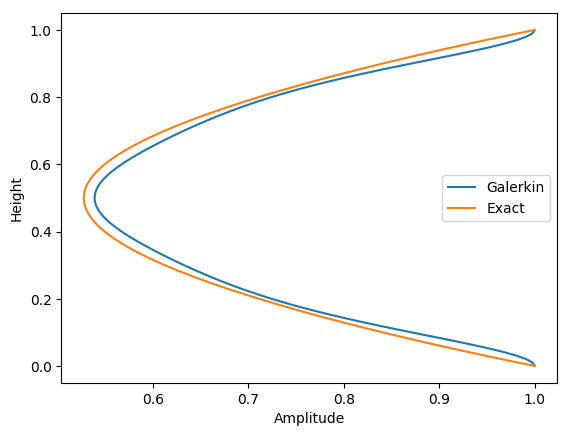

In [185]:
using PyPlot
ioff()

nodePoints = 200 # redefining for ease of alteration
matrixSize = 7

first_coefficient = 0.5
kxStart = 0.1
kxFinish = 10.
steps = 100
beta = 0
ky = 0
kxs = linspace(kxStart, kxFinish, steps) 
eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates_eady_four, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxs)

createFourStabilityPlotsCompareToExact(matrixSize, S_constant, growthRates_eady_four, vectors, w_speeds, kxs, ky)

In [ ]:
kxs = 1.61
eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxs)

# Eady Verification Test

In [ ]:
using PyPlot
ioff()

matrixSize = 5
first_coefficient = 0.5

kxStart = 0.1
kxFinish = 10.
steps = 100
beta = 0
ky = 0
kxs = linspace(kxStart, kxFinish, steps)
eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxs)

createFourStabilityPlots(matrixSize, S_constant, growthRates, vectors, w_speeds, w_minSpeeds, kxs, ky)

# Green Problem

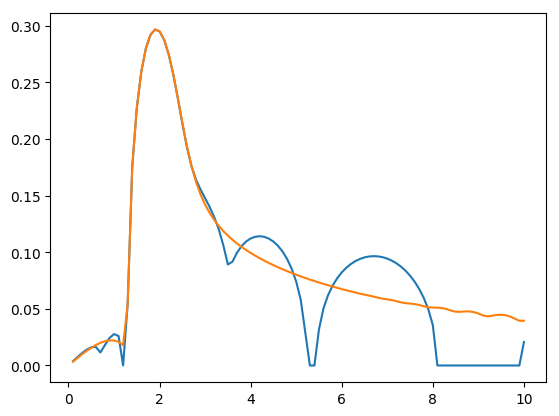

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005B9088D0>

In [275]:
using PyPlot
ioff()

matrixSize = 16
first_coefficient = 0.5

kxStart = 0.1
kxFinish = 10.
steps = 100
beta = 1
ky = 0
kxs = linspace(kxStart, kxFinish, steps)
eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates_green_16, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxs)

matrixSize = 128
eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates_green_128, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxs)



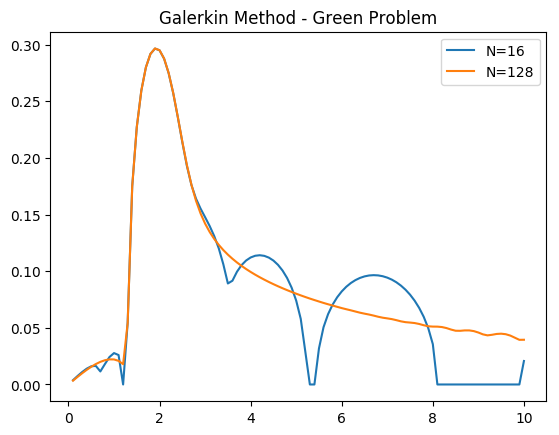

In [279]:
steps = 100
ky = 0
kxs = linspace(kxStart, kxFinish, steps)
plot(kxs, growthRates_green_16, label="N=16")
plot(kxs,growthRates_green_128, label="N=128")

title("Galerkin Method - Green Problem")
legend(loc="upper right")
savefig("G_Green.eps", format="eps", dpi=1000)

# Ocean-Charney Stability

In [78]:
function u_OC(value)
    if(value isa Number)
        return 1/54*(3*exp(6*value -6)*(6*value -1) -2 -exp(-6))
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = 1/54*(3*exp(6*value[i] -6)*(6*value[i] -1) -2 +exp(-6))
        end
        return vector
    end
end

function dq_OC(value)  
    if(value isa Number)
        return -2
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = -2
        end
        return vector
    end
end

function S_OC(value)
    if(value isa Number)
        return exp(6-6*value)
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = exp(6-6*value[i])
        end
        return vector
    end
end
   
function du_OC(value)
    if(value isa Number)
        return 2*value*exp(6*(value-1))
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = 2*value[i]*exp(6*(value[i]-1))
        end
        return vector
    end
end

du_OC (generic function with 1 method)

In [38]:
using PyPlot

first_coefficient = 0
matrixSize = 32

kxStart = 0.1
kxFinish = 20.
steps = 200
beta = 1
ky = 0
kxs = linspace(kxStart, kxFinish, steps)

#= Test set 
(B,L,M,U,Q,u_coefficients,dq_coefficients) = computeMatricesForStabilityAnalysis(matrixSize,S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
testPoint = 0.9
realValue = u_OC(testPoint)
galerkinValue = u_galerkin(matrixSize, u_coefficients, testPoint)
x = 0.1:0.01:0.9
plot(x, u_OC(x), x, u_galerkin(matrixSize, u_coefficients, x))
=#

eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
growthRates_OC_32, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxs)

println("Done with 32")
matrixSize = 256
eigenValuesAndVectors_3 = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
growthRates__OC_256, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors_3, kxs)

fig, axes = subplots(1,2)
ax = axes[1]
ax[:plot](kxs, growthRates_OC_32, label="N=32")
ax[:legend](loc="upper right")
ax = axes[2]
ax[:plot](kxs, growthRates__OC_256, label="N=256")
ax[:legend](loc="upper right")
#createFourStabilityPlots(matrixSize, S_OC, growthRates, vectors, w_speeds, w_minSpeeds, kxs, ky)

Done with 32


LoadError: [91mUndefVarError: growthRates not defined[39m

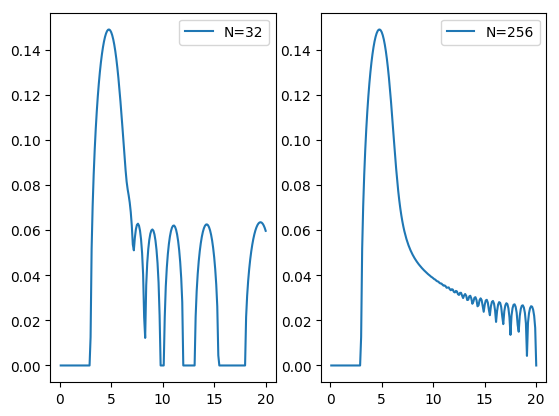

PyObject <matplotlib.legend.Legend object at 0x0000000052F0E160>

In [71]:
fig, axes = subplots(1,2)
ax = axes[1]
ax[:plot](kxs, growthRates_OC_32, label="N=32")
ax[:legend](loc="upper right")
ax = axes[2]
ax[:plot](kxs, growthRates__OC_256, label="N=256")
ax[:legend](loc="upper right")

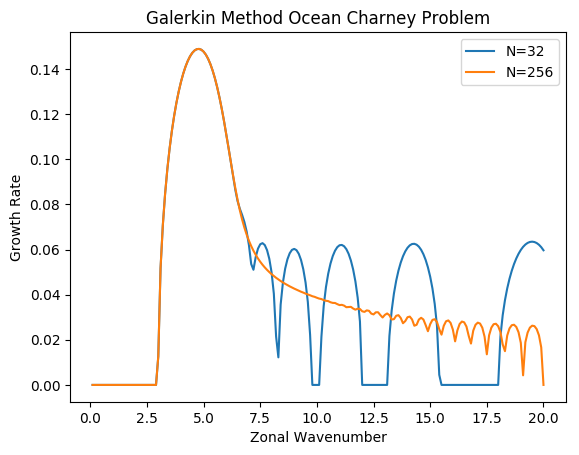

In [93]:
kxStart = 0.1
kxFinish = 20.
steps = 200
kxs_OC_G = linspace(kxStart, kxFinish, steps)
plot(kxs_OC_G, growthRates_OC_32, label="N=32")
plot(kxs_OC_G, growthRates__OC_256, label="N=256")
legend(loc="upper right")
title("Galerkin Method Ocean Charney Problem")
xlabel("Zonal Wavenumber")
ylabel("Growth Rate")
savefig("G_OceanCharney.eps", format="eps", dpi=1000)

In [271]:
first_coefficient = 0
matrixSize = 256

beta = 1
ky = 0
kValue_OC_High = 8.

eigenValuesAndVectors_OC_256_Galerkin_8 = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kValue_OC_High, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
growthRates_OC_256_Galerking_8, vectors_OC_256_Galerkin_8, w_speeds_OC_256_Galerkin, w_minSpeeds_OC_256_Galerkin = getStabilityValues(eigenValuesAndVectors_OC_256_Galerkin, kValue_OC_High)

([0.0515038], Any[Complex{Float64}[0.694171+0.138929im, -0.0236875+0.103318im, 0.206252+0.176397im, 0.300905+0.0732998im, 0.206102-0.120528im, -0.0298028-0.256674im, -0.253142-0.225358im, -0.321952-0.0323178im, -0.154788+0.186351im, 0.133469+0.296162im  …  0.317209+0.0450064im, 0.0276731+0.32513im, 0.421012+0.149031im, 0.00469037+0.149226im, 0.300948-0.0423855im, -0.237994+0.359823im, 0.321125+0.387262im, 0.297845+0.410693im, 0.792587-0.0523657im, 0.0+0.0im]], [0.0422114], [-0.0805985])

In [269]:
first_coefficient = 0
matrixSize = 256

beta = 1
ky = 0
kValue_OC_High = 7.5

eigenValuesAndVectors_OC_256_Galerkin = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kValue_OC_High, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
growthRates_OC_256_Galerking, vectors_OC_256_Galerkin, w_speeds_OC_256_Galerkin, w_minSpeeds_OC_256_Galerkin = getStabilityValues(eigenValuesAndVectors_OC_256_Galerkin, kValue_OC_High)

([0.0482848], Any[Complex{Float64}[0.694171+0.138929im, -0.0236875+0.103318im, 0.206252+0.176397im, 0.300905+0.0732998im, 0.206102-0.120528im, -0.0298028-0.256674im, -0.253142-0.225358im, -0.321952-0.0323178im, -0.154788+0.186351im, 0.133469+0.296162im  …  0.317209+0.0450064im, 0.0276731+0.32513im, 0.421012+0.149031im, 0.00469037+0.149226im, 0.300948-0.0423855im, -0.237994+0.359823im, 0.321125+0.387262im, 0.297845+0.410693im, 0.792587-0.0523657im, 0.0+0.0im]], [0.0422114], [-0.0805985])

In [199]:
B = B_ij(matrixSize)
L = L_ij(matrixSize, S_OC)
M = M_ij(matrixSize)

done with matrices


LoadError: [91mUndefVarError: sizeOfMatrix not defined[39m

In [202]:
maxIndex = indmax(growthRates_OC_256_Galerking)
maxKx = kValue_OC_High
highVector = vectors_OC_256_Galerkin[maxIndex]
vectorSize = length(highVector)
highVector_bottom = highVector[vectorSize] 
psi_coeffs = highVector[1]*psi(matrixSize, maxKx, ky, M, L, 1.)-highVector_bottom*psi(matrixSize,maxKx,ky, M,L,0.)
psi_coeffs = psi_coeffs - ( (maxKx^2 + ky^2)*M + L ) \ B*highVector[2:end-1];

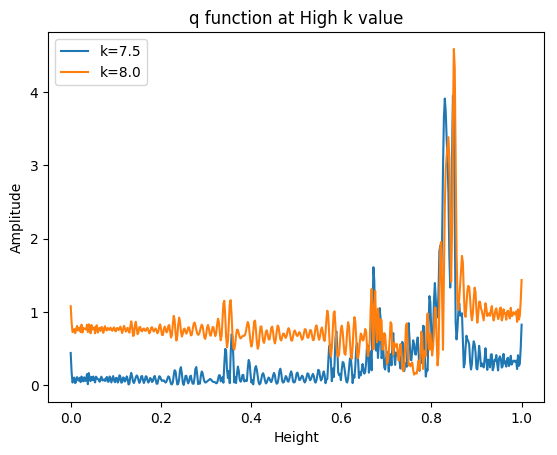

In [281]:
heights = linspace(0,1,500)
maxIndex = indmax(growthRates_OC_256_Galerking)
highVector = vectors_OC_256_Galerkin[maxIndex]
q_coeffs_256 = highVector[2:end-1]
q_coeffs_256_8 = vectors_OC_256_Galerkin_8[1]
u_values_256_OC = zeros(length(heights))
u_values_256_OC_8 = zeros(length(heights))
for i=1:length(heights)
    u_value_full = u_galerkin(256, q_coeffs_256, heights[i])
    u_value_full_8 = u_galerkin(256, q_coeffs_256_8, heights[i])
    u_values_256_OC[i] = abs(u_value_full)
    u_values_256_OC_8[i] = abs(u_value_full_8)
end
plot(heights, u_values_256_OC, label="k=7.5")
plot(heights, u_values_256_OC_8, label="k=8.0")
legend(loc="upper left")
title("q function at High k value")
xlabel("Height")
ylabel("Amplitude")
savefig("OceanCharney_qfunction.eps", format="eps", dpi=1000)

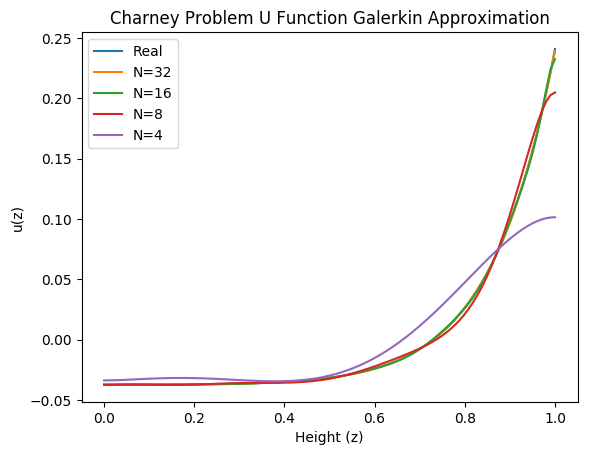

In [282]:
matrixSize = 32
B_32 = B_ij(matrixSize)
L_32 = L_ij(matrixSize, S_OC)
dq_coefficients_OC_32 = dq_galerkin_coefficients(matrixSize, dq_OC)
u_coefficients_32 = u_galerkin_coefficients(matrixSize, dq_coefficients_OC_32, -2., 0, 0, du_OC, S_OC, L_32, B_32)

matrixSize = 16
B_16 = B_ij(matrixSize)
L_16 = L_ij(matrixSize, S_OC)
dq_coefficients_OC_16 = dq_galerkin_coefficients(matrixSize, dq_OC)
u_coefficients_16 = u_galerkin_coefficients(matrixSize, dq_coefficients_OC_16, -2., 0, 0, du_OC, S_OC, L_16, B_16)

matrixSize = 8
B_8 = B_ij(matrixSize)
L_8 = L_ij(matrixSize, S_OC)
dq_coefficients_OC_8 = dq_galerkin_coefficients(matrixSize, dq_OC)
u_coefficients_8 = u_galerkin_coefficients(matrixSize, dq_coefficients_OC_8, -2., 0, 0, du_OC, S_OC, L_8, B_8)

matrixSize = 4
B_4 = B_ij(matrixSize)
L_4 = L_ij(matrixSize, S_OC)
dq_coefficients_OC = dq_galerkin_coefficients(matrixSize, dq_OC)
u_coefficients_4 = u_galerkin_coefficients(matrixSize, dq_coefficients_OC, -2., 0, 0, du_OC, S_OC, L_4, B_4)

n_32_values = zeros(100)
n_16_values = zeros(100)
n_8_values = zeros(100)
n_4_values = zeros(100)
heights = linspace(0,1,100)
real_Values = u_OC(heights)

for i=1:length(heights)
    n_32_values[i] = u_galerkin(32, u_coefficients_32, heights[i])
    n_16_values[i] = u_galerkin(16, u_coefficients_16, heights[i])
    n_8_values[i] = u_galerkin(8, u_coefficients_8, heights[i])
    n_4_values[i] = u_galerkin(4, u_coefficients_4, heights[i])
end

plot(heights, real_Values, label="Real")
plot(heights, n_32_values, label="N=32")
plot(heights, n_16_values, label="N=16")
plot(heights, n_8_values, label="N=8")
plot(heights, n_4_values, label="N=4")
legend(loc="upper left")
xlabel("Height (z)")
ylabel("u(z)")
title("Charney Problem U Function Galerkin Approximation")
savefig("UFunctions.eps", format="eps", dpi=1000)

# Phillips Stability

In [39]:
function u_Phillips(value)
    if(value isa Number)
        return -cos(pi*value)/pi
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = -cos(pi*value[i])/pi
        end
        return vector
    end
end

function dq_Phillips(value)  
    if(value isa Number)
        return pi*cos(pi*value)
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = pi*cos(pi*value[i])
        end
        return vector
    end
end

function S_Phillips(value)
    if(value isa Number)
        return 1
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = 1
        end
        return vector
    end
end
   
function du_Phillips(value)
    if(value isa Number)
        return sin(pi*value)
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = sin(pi*value[i])
        end
        return vector
    end
end

du_Phillips (generic function with 1 method)

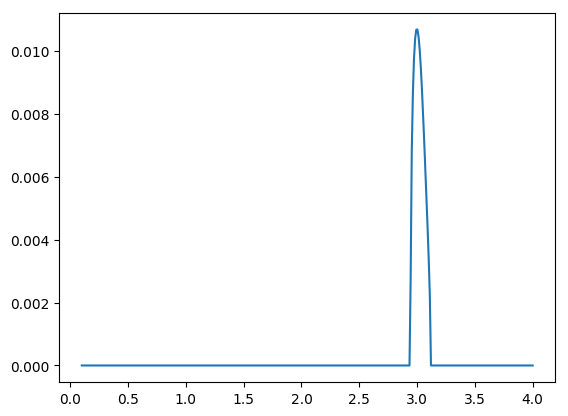

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000043B7AE10>

In [156]:
using PyPlot
first_coefficient = 0
matrixSize = 13

kxStart = 0.1
kxFinish = 4.
steps = 400
beta = 3.1
ky = 0
kxs = linspace(kxStart, kxFinish, steps)
eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_Phillips, dq_Phillips, du_Phillips, 0, 0, first_coefficient)
growthRates_13_Phil, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxs)

plot(kxs, growthRates_13_Phil, label="Growth Rates at N = 13")
#legend(loc="upper right")

In [17]:
nValues = round.(Int64,logspace(0.8, 2.408,15))
growthRates_forN_Phil = zeros(length(nValues))
kxValue = 3.
for i =1:length(nValues)
    matrixSize = nValues[i]
    println("Working on $matrixSize")
    eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxValue, S_Phillips, dq_Phillips, du_Phillips, 0, 0, first_coefficient)
    growthRate, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxValue)
    growthRates_forN_Phil[i] = growthRate[1]
end

semilogy(nValues, abs.(growthRates_forN_Phil-growthRates_280_Phil[1], label="Growth Rate Approach")
legend(loc="upper right")


Working on 6
Working on 8
Working on 11
Working on 14
Working on 18
Working on 24
Working on 31
Working on 40
Working on 52
Working on 68
Working on 89
Working on 116
Working on 151
Working on 196
Working on 256


LoadError: [91mDimensionMismatch("dimensions must match")[39m

In [161]:
matrixSize = 280
first_coefficient = 0
beta = 3.1
ky = 0
kxValue = 3.
eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxValue, S_Phillips, dq_Phillips, du_Phillips, 0, 0, first_coefficient)
growthRates_280_Phil_G, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxValue)


([0.0108993], Any[Complex{Float64}[0.0+0.0im, 0.803211+0.196789im, -0.348818-0.147494im, -0.24963-0.165832im, -0.162534-0.193314im, -0.102787-0.215415im, -0.0268704-0.20589im, 0.0428914-0.168412im, 0.0923641-0.112371im, 0.115442-0.0496831im  …  3.64206e-13-5.75156e-13im, 1.46703e-13-8.07978e-13im, -1.77348e-13-1.01832e-12im, -3.49247e-13-1.05188e-12im, -5.78334e-13-1.06353e-12im, -5.15921e-13-8.66522e-13im, -4.82232e-13-6.703e-13im, -2.93793e-13-3.67578e-13im, -1.59011e-13-1.74623e-13im, 0.0+0.0im]], [-0.317815], [-0.31831])

0.01089265218955414
Working on 6
[0.0]
Working on 8
[0.0120663]
Working on 11
[0.0114702]
Working on 14
[0.0106184]
Working on 18
[0.0109736]
Working on 24
[0.0108985]
Working on 31
[0.0108986]
Working on 40
[0.0108994]
Working on 52
[0.0108993]
Working on 68
[0.0108993]
Working on 89
[0.0108993]
Working on 116
[0.0108993]
Working on 151
[0.0108993]
Working on 196
[0.0108993]
Working on 256


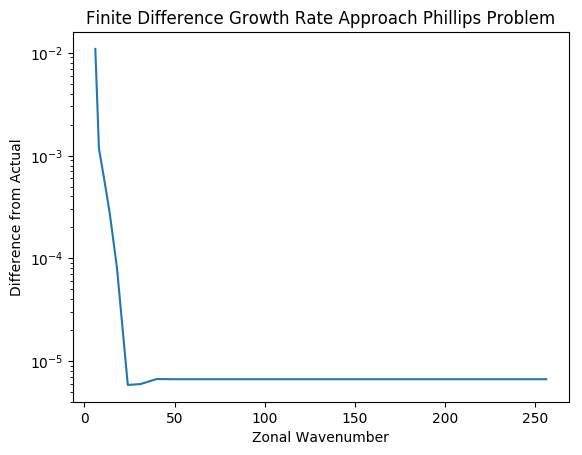

[0.0108993]


PyObject <matplotlib.text.Text object at 0x000000004408A630>

In [159]:
first_coefficient = 0
beta = 3.1
ky = 0
bestPoint, bestKxIndex_Phil = findmax(growthRates_Phil_fd)
nValues = round.(Int64,logspace(0.8, 2.408,15))
growthRates_forN_Phil_G = zeros(length(nValues))
kxValue = 3.
println(bestPoint)
for i =1:length(nValues)
    matrixSize = nValues[i]
    println("Working on $matrixSize")
    eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxValue, S_Phillips, dq_Phillips, du_Phillips, 0, 0, first_coefficient)
    growthRate, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxValue)
    growthRates_forN_Phil_G[i] = growthRate[1]
    println(growthRate)
end

plot(nValues, abs.(growthRates_forN_Phil_G-bestPoint))
yscale("log")
title("Finite Difference Growth Rate Approach Phillips Problem")
xlabel("Zonal Wavenumber")
ylabel("Difference from Actual")

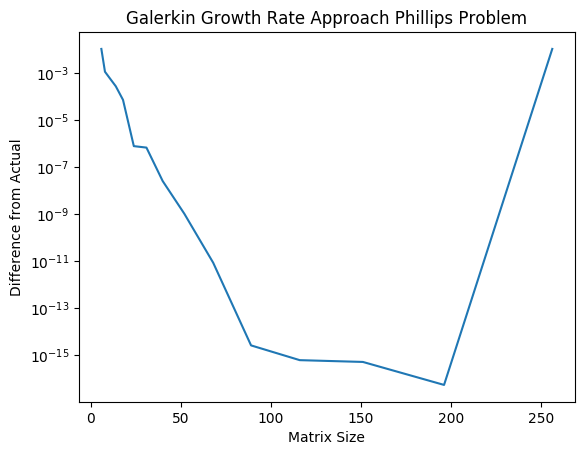

In [169]:
bestPoint = growthRates_280_Phil_G[1]
plot(nValues, abs.(growthRates_forN_Phil-bestPoint))
yscale("log")
title("Galerkin Growth Rate Approach Phillips Problem")
xlabel("Matrix Size")
ylabel("Difference from Actual")
savefig("PhillipsProblemApproachFull.eps", format="eps", dpi=1000)

# First Baroclinic Mode Comparison

In [ ]:
using PyPlot

function isNonZero(value)
    return (value != 0)
end

function firstBaroclinic(value)
    return cos.(pi*value)
end

function computeFirstBaroclinicError(matrixSize, trueFirstFuction, stepsZeroToOne, S_function)
    #Compute Matricies
    M = M_ij(matrixSize)
    #spy(Hermitian(M))
    L = L_ij(matrixSize, S_function)
    G = chol(M)'

    #Compute eigenvalues and eigenvectors
    LGL = (G\L)/(G')
    eigenObject = eigfact(LGL)
    e_vectors = eigenObject[:vectors]
    e_values = eigenObject[:values]
    minimumNonZero = minimum(filter!(isNonZero,e_values))
    index = findfirst(e_values, minimumNonZero)
    neededEVector = e_vectors[:,index]
    neededEVector = (LGL - e_values[index]*eye(matrixSize))\neededEVector
    neededEVector = G'\neededEVector
    #println(neededEVector)
#    normalizationFactor = 1./galerkin_p_psi_print(matrixSize, neededEVector, 0.)
    
    #Calculate Error
    z, weights = gausslegendre(stepsZeroToOne)
    real = trueFirstFuction(z)
    estimate = galerkin_p_psi_print(matrixSize, neededEVector, z)
    normalizationFactor = dot(weights,real.*estimate)/dot(weights,estimate.*estimate)
    estimate = normalizationFactor*estimate
    #println("True Values: $real")
    #println("Appx Values: $estimate")
    #println()
#    sumError = 0.
#    for i=1:length(z)
#        sumError += abs2(real[i]-estimate[i])
#    end
#    totalError = sqrt(sumError/stepsZeroToOne)
    totalError = sqrt(dot(weights,abs2.(real-estimate)))
    return totalError
end

#computeFirstBaroclinicError(15, firstBaroclinic, 10)

errors = zeros(20)
nValues = 3:22;
for i =nValues
    #println("N = $i")
    errors[i-2] = computeFirstBaroclinicError(i, firstBaroclinic, 201, S_constant)
    #println()
end
#plot(nValues,errors)
loglog(nValues[2:2:end], errors[2:2:end])

# Finite Difference Analysis

In [9]:
function z_elements(size)
    stepSize = 1/size
    elements = zeros(size)
    elements[1] = stepSize/2
    for i = 2:size
        elements[i] = elements[i-1]+stepSize;
    end
    return elements
end

function U_fd(size, u_function)
    z_k = z_elements(size)
    fullMatrix = Diagonal(u_function(z_k))
    return fullMatrix
end

function L_fd(size, S)
    deltaZ = 1/size
    fullMatrix = zeros(size, size)
    fullMatrix[1,1] = S(deltaZ)
    fullMatrix[1,2] = -S(deltaZ)
    fullMatrix[size,size] = S((size-1)*deltaZ)
    fullMatrix[size,size-1] = -S((size-1)*deltaZ)
    for i=2:size-1
        fullMatrix[i, i-1] = -S((i-1)*deltaZ)
        fullMatrix[i,i] = S((i-1)*deltaZ)+S(i*deltaZ)
        fullMatrix[i, i+1] = -S(i*deltaZ)
    end
    normalize = 1./(deltaZ^2)
    return fullMatrix*normalize
end

function Q_fd(size, u_function, L_matrix)
    zk = z_elements(size)
    u_matrix = u_function(zk)
    diagonals = L_matrix*u_matrix
    fullMatrix = Diagonal(diagonals)
    return fullMatrix
end

#z_elements(8)
#L = L_fd(5, z_linear)
#Q_fd(5,u_linear,L)

Q_fd (generic function with 1 method)

In [10]:
function u_linear(value)
    return value
end

function growthRateEigenValues_fd(sizeOfMatrix, beta_value, ky, kxValues, S_function, u_function)
    U = U_fd(sizeOfMatrix, u_function)
    L = L_fd(sizeOfMatrix, S_function)
    Q = Q_fd(sizeOfMatrix, u_function, L)
    #println("FD Matrices Computed")
    
    steps = length(kxValues)
    
    growthRates = zeros(steps)
    waveSpeeds = zeros(steps)
    minWaveSpeeds = zeros(steps)
    eigenvectors = []
    for i=1:steps
        #println()
        kx = kxValues[i]
        lhs = U*(Diagonal(zeros(sizeOfMatrix)+(kx^2+ky^2))+L) - (Q+Diagonal(zeros(sizeOfMatrix)+beta_value))
        rhs = Diagonal(zeros(sizeOfMatrix)+(kx^2+ky^2))+L
        #println(lhs)
        eigenObject = eigfact(lhs, rhs)
        max_im, max_ind = findmax(imag(eigenObject[:values]))
        #println(eigenObject[:vectors])
        append!(eigenvectors, [eigenObject[:vectors][:,max_ind]])
        waveSpeeds[i] = real(eigenObject[:values][max_ind])
        minWaveSpeeds[i] = minimum(real(eigenObject[:values]))
        growthRates[i] = max_im*kx
    end
    return growthRates, eigenvectors, waveSpeeds, minWaveSpeeds
end

growthRateEigenValues_fd (generic function with 1 method)

# Finite Difference - Eady Problem

In [ ]:
using PyPlot
matrixSize = 7

kxStart = 0.1
kxFinish = 10.
steps = 1000
beta = 0
ky = 0

kxs = linspace(kxStart, kxFinish, steps)
growthRates, vectors, w_speeds, w_minSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_constant, u_linear)
plot(kxs, growthRates)

## FD - Green Problem

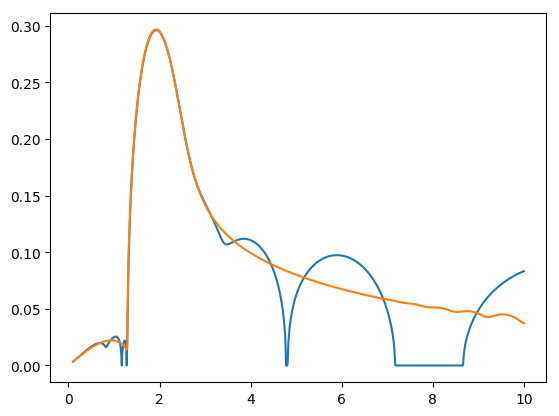

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005B96D9E8>

In [276]:
using PyPlot
matrixSize = 16

kxStart = 0.1
kxFinish = 10.
steps = 1000
beta = 1
ky = 0

kxs = linspace(kxStart, kxFinish, steps)
growthRates_fd_green_16, vectors, w_speeds, w_minSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_constant, u_linear)

matrixSize = 128
growthRates_fd_green_128, vectors, w_speeds, w_minSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_constant, u_linear)



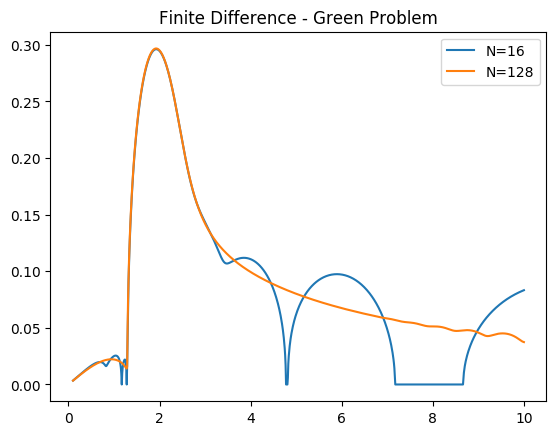

In [277]:

plot(kxs, growthRates_fd_green_16, label="N=16")
plot(kxs, growthRates_fd_green_128, label="N=128")
title("Finite Difference - Green Problem")
legend(loc="upper right")
savefig("FDGreen.eps", format="eps", dpi=1000)

# Comparison Finite Difference to Galerkin

In [35]:
using PyPlot
ion()

nodePoints = 300 # redefining for ease of alteration

first_coefficient = 0.5
steps = 1
beta = 0
ky = 0
kxs = 1.61

nValues = round.(Int64,logspace(0.8, 2.408,15))
println(nValues)
growthRates_galerkin_eady = zeros(length(nValues))
growthRates_fd_eady = zeros(length(nValues))

bestValue_eady = 1.61*imag(c(1.61))

for i = 1:length(nValues)
    nV = round(Int64, nValues[i])
    matrixSize = nV
    println("Working on $nV")
    eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
    growthRate_g, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxs)
    growthRates_galerkin_eady[i] = growthRate_g[1]
    
    matrixSize = nV + 2
    growthRate_fd, vectors_fd, w_speeds_fd, w_minSpeeds_fd = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_constant, u_linear)
    growthRates_fd_eady[i] = growthRate_fd[1]
end

loglog(nValues, abs.(growthRates_galerkin_eady-bestValue_eady), label="Galerkin")
loglog(nValues, abs.(growthRates_fd_eady-bestValue_eady), label="FD")
legend(loc="upper right")

[6, 8, 11, 14, 18, 24, 31, 40, 52, 68, 89, 116, 151, 196, 256]
Working on 6
Working on 8
Working on 11
Working on 14
Working on 18
Working on 24
Working on 31
Working on 40
Working on 52
Working on 68
Working on 89
Working on 116
Working on 151
Working on 196
Working on 256


LoadError: [91mPyError (ccall(@pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, arg, kw)) <class 'ValueError'>
ValueError('Data has no positive values, and therefore can not be log-scaled.',)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\pyplot.py", line 3178, in loglog
    ret = ax.loglog(*args, **kwargs)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axes\_axes.py", line 1538, in loglog
    self.set_xscale('log', **dx)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axes\_base.py", line 2962, in set_xscale
    ax.xaxis._set_scale(value, **kwargs)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axis.py", line 710, in _set_scale
    self._scale.set_default_locators_and_formatters(self)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\scale.py", line 249, in set_default_locators_and_formatters
    axis.set_major_locator(LogLocator(self.base))
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axis.py", line 1543, in set_major_locator
    self.stale = True
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\artist.py", line 279, in stale
    self.stale_callback(self, val)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\artist.py", line 76, in _stale_axes_callback
    self.axes.stale = val
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\artist.py", line 279, in stale
    self.stale_callback(self, val)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\figure.py", line 56, in _stale_figure_callback
    self.figure.stale = val
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\artist.py", line 279, in stale
    self.stale_callback(self, val)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\pyplot.py", line 576, in _auto_draw_if_interactive
    fig.canvas.draw_idle()
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\backend_bases.py", line 2040, in draw_idle
    self.draw(*args, **kwargs)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\backends\backend_agg.py", line 464, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\artist.py", line 63, in draw_wrapper
    draw(artist, renderer, *args, **kwargs)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\figure.py", line 1144, in draw
    renderer, self, dsu, self.suppressComposite)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\image.py", line 139, in _draw_list_compositing_images
    a.draw(renderer)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\artist.py", line 63, in draw_wrapper
    draw(artist, renderer, *args, **kwargs)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axes\_base.py", line 2426, in draw
    mimage._draw_list_compositing_images(renderer, self, dsu)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\image.py", line 139, in _draw_list_compositing_images
    a.draw(renderer)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\artist.py", line 63, in draw_wrapper
    draw(artist, renderer, *args, **kwargs)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axis.py", line 1136, in draw
    ticks_to_draw = self._update_ticks(renderer)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axis.py", line 969, in _update_ticks
    tick_tups = [t for t in self.iter_ticks()]
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axis.py", line 969, in <listcomp>
    tick_tups = [t for t in self.iter_ticks()]
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axis.py", line 912, in iter_ticks
    majorLocs = self.major.locator()
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\ticker.py", line 1930, in __call__
    return self.tick_values(vmin, vmax)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\ticker.py", line 1956, in tick_values
    "Data has no positive values, and therefore can not be "
[39m

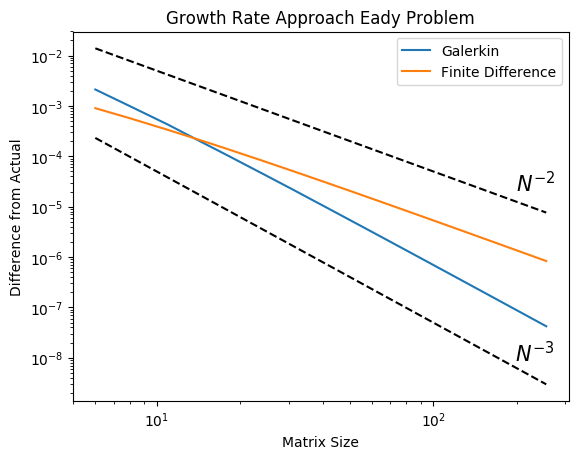

In [166]:
diffs = abs.(growthRates_galerkin_eady-bestValue_eady)
diffs_fd = abs.(growthRates_fd_eady-bestValue_eady)
wholes = round.(nValues)
plot(wholes,diffs, label="Galerkin")
plot(wholes,diffs_fd, label="Finite Difference")
plot(wholes, .5*float(wholes).^-2, color="k", linestyle="dashed")
plot(wholes, .05*float(wholes).^-3, color="k", linestyle="dashed")
title("Growth Rate Approach Eady Problem")
xlabel("Matrix Size")
ylabel("Difference from Actual")
yscale("log")
xscale("log")
legend(loc="upper right")
annotate(L"$N^{-2}$",
	xy=[1;0.52],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
annotate(L"$N^{-3}$",
	xy=[1;0.06],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
savefig("EadyApproach.eps", format="eps", dpi=1000)

# Finite Difference - Ocean Charney

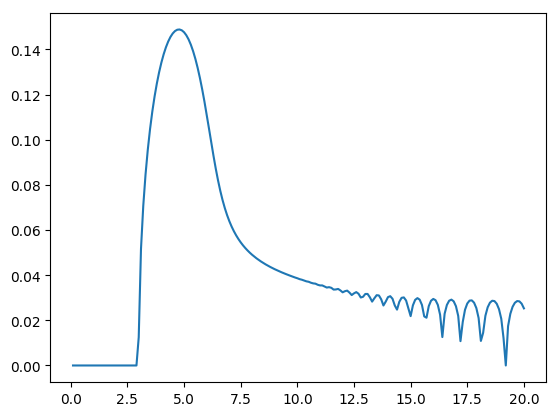

PyObject <matplotlib.legend.Legend object at 0x0000000055D85CC0>

In [76]:
using PyPlot

matrixSize = 280

kxStart = 0.1
kxFinish = 20.
steps = 200
beta = 1
ky = 0

kxs = linspace(kxStart, kxFinish, steps)
growthRates_fd_280_OC, vectors, w_speeds, w_minSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_OC, u_OC)
plot(kxs, growthRates_fd_280_OC, label="N = $matrixSize")

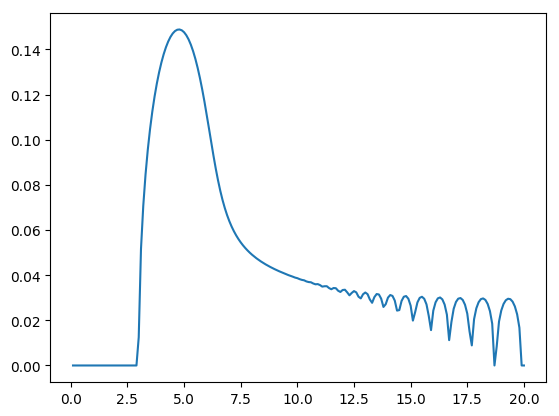

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000004140F98>

In [83]:
matrixSize = 256

kxStart = 0.1
kxFinish = 20.
steps = 200
beta = 1
ky = 0

kxs = linspace(kxStart, kxFinish, steps)
growthRates_fd_256_OC, vectors, w_speeds, w_minSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_OC, u_OC)
matrixSize = 32
growthRates_fd_32_OC, vectors, w_speeds, w_minSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_OC, u_OC)

plot(kxs, growthRates_fd_32_OC, label="N = 32")
plot(kxs, growthRates_fd_256_OC, label="N = 256")

In [187]:
plot(kxs, growthRates_fd_32_OC, label="N = 32")
plot(kxs, growthRates_fd_256_OC, label="N = 256")
legend(loc="upper right")
title("Finite Difference Ocean Charney Problem")
xlabel("Zonal Wavenumber")
ylabel("Growth Rate")
savefig("FD_OceanCharney.eps", format="eps", dpi=1000)

LoadError: [91mPyError (ccall(@pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, arg, kw)) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (100,) and (200,)',)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\pyplot.py", line 3317, in plot
    ret = ax.plot(*args, **kwargs)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\__init__.py", line 1898, in inner
    return func(ax, *args, **kwargs)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axes\_axes.py", line 1406, in plot
    for line in self._get_lines(*args, **kwargs):
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axes\_base.py", line 407, in _grab_next_args
    for seg in self._plot_args(remaining, kwargs):
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axes\_base.py", line 385, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "C:\Users\mwatwood\AppData\Local\JuliaPro-0.6.2.2\Python\lib\site-packages\matplotlib\axes\_base.py", line 244, in _xy_from_xy
    "have shapes {} and {}".format(x.shape, y.shape))
[39m

4.8
Working on 6
[0.145437]
Working on 8
[0.148864]
Working on 11
[0.148741]
Working on 14
[0.148896]
Working on 18
[0.148897]
Working on 24
[0.148877]
Working on 31
[0.148874]
Working on 40
[0.148874]
Working on 52
[0.148874]
Working on 68
[0.148874]
Working on 89
[0.148874]
Working on 116
[0.148874]
Working on 151
[0.148874]
Working on 196
[0.148874]
Working on 256
[0.149023]


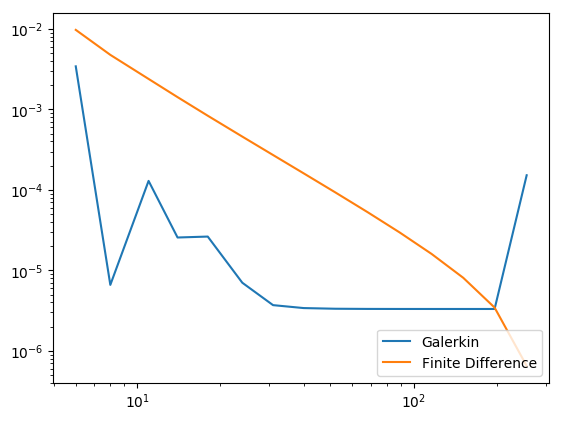

[0.145437, 0.148864, 0.148741, 0.148896, 0.148897, 0.148877, 0.148874, 0.148874, 0.148874, 0.148874, 0.148874, 0.148874, 0.148874, 0.148874, 0.149023]
[0.139124, 0.144102, 0.146475, 0.147447, 0.148034, 0.14841, 0.148599, 0.14871, 0.148777, 0.148817, 0.148841, 0.148854, 0.148862, 0.148867, 0.14887]
(0.1488703140734919, 48)


PyObject <matplotlib.legend.Legend object at 0x000000005B204828>

In [188]:
first_coefficient = 0

kxStart = 0.1
kxFinish = 20.
steps = 200
beta = 1
ky = 0

nValues = round.(Int64,logspace(0.8, 2.408,15))
growthRates_galerkin_OC=zeros(length(nValues))
growthRates_fd_OC = zeros(length(nValues))

bestValue_OC = findmax(growthRates_fd_280_OC)
kxValue = kxs[bestValue_OC[2]]
println(kxValue)

for i = 1:length(nValues)
    nV = round(Int64, nValues[i])
    matrixSize = nV
    println("Working on $nV")
    eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxValue, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
    growthRates_g, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxValue)
    growthRates_galerkin_OC[i] = growthRates_g[1]
    println(growthRates_g)
    growthRates_fd, vectors_fd, w_speeds_fd, w_minSpeeds_fd = growthRateEigenValues_fd(matrixSize, beta, ky, kxValue, S_OC, u_OC)
    growthRates_fd_OC[i] = growthRates_fd[1]
end

println(growthRates_galerkin_OC)
println(growthRates_fd_OC)
println(bestValue_OC)
plot(nValues,abs.(growthRates_galerkin_OC-bestValue_OC[1]), label="Galerkin")
plot(nValues, abs.(growthRates_fd_OC-bestValue_OC[1]), label="Finite Difference")
yscale("log")
xscale("log")
legend(loc="lower right")

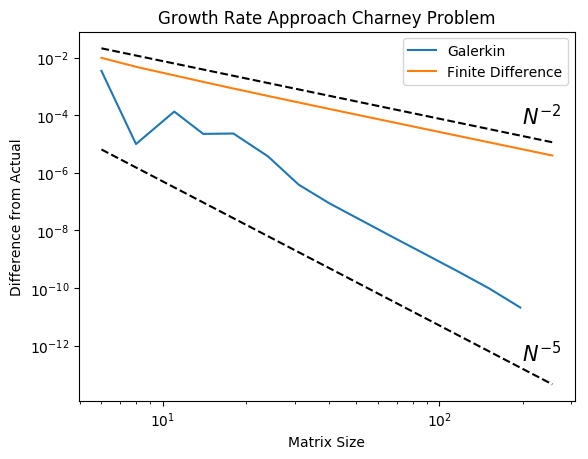

[0.145437, 0.148864, 0.148741, 0.148896, 0.148897, 0.148877, 0.148874, 0.148874, 0.148874, 0.148874, 0.148874, 0.148874, 0.148874, 0.148874, 0.149023]
[0.139124, 0.144102, 0.146475, 0.147447, 0.148034, 0.14841, 0.148599, 0.14871, 0.148777, 0.148817, 0.148841, 0.148854, 0.148862, 0.148867, 0.14887]
(0.14887363155005048, 48)


In [242]:
bestValue_OC= findmax(growthRates__OC_256)
println(growthRates_galerkin_OC)
println(growthRates_fd_OC)
println(bestValue_OC)
plot(nValues[1:end-1],abs.(growthRates_galerkin_OC[1:end-1]-bestValue_OC[1]), label="Galerkin")
plot(nValues, abs.(growthRates_fd_OC-bestValue_OC[1]), label="Finite Difference")
plot(wholes, .75*float(wholes).^-2, color="k", linestyle="dashed")
plot(wholes, .05*float(wholes).^-5, color="k", linestyle="dashed")
title("Growth Rate Approach Charney Problem")
xlabel("Matrix Size")
ylabel("Difference from Actual")
yscale("log")
xscale("log")
legend(loc="upper right")
annotate(L"$N^{-2}$",
	xy=[1;0.7],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
annotate(L"$N^{-5}$",
	xy=[1;0.06],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
savefig("OCApproach.eps", format="eps", dpi=1000)

# Finite Difference - Phillips

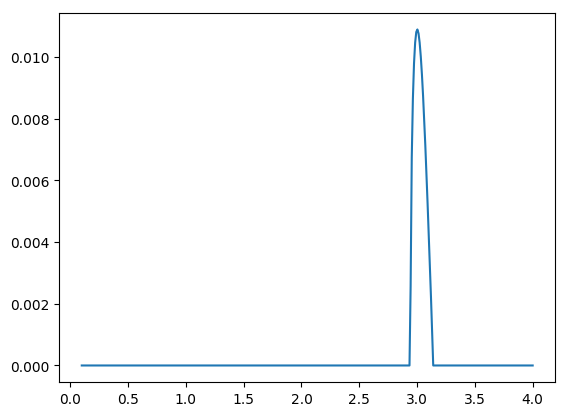

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002E70F668>

In [11]:
using PyPlot

matrixSize = 280

kxStart = .1
kxFinish = 4.
steps = 400
beta = 3.1
ky = 0

kxs = linspace(kxStart, kxFinish, steps)
growthRates_Phil_fd, vectors, w_speeds, w_minSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_Phillips, u_Phillips)
plot(kxs,growthRates_Phil_fd)

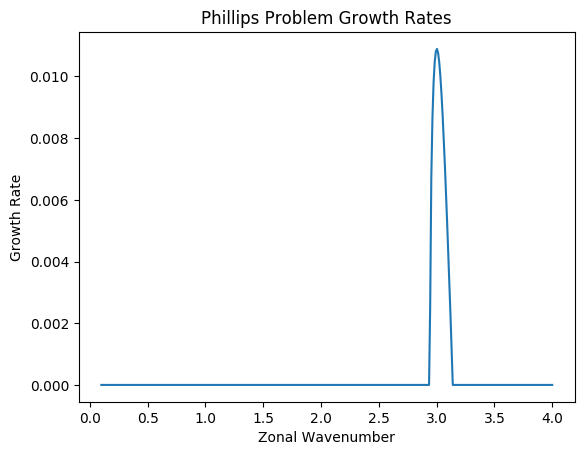

In [116]:
kxStart = .1
kxFinish = 4.
steps = 400
beta = 3.1
ky = 0

kxs = linspace(kxStart, kxFinish, steps)
plot(kxs,growthRates_Phil_fd)
title("Phillips Problem Growth Rates")
xlabel("Zonal Wavenumber")
ylabel("Growth Rate")
savefig("PhillipsProblem.eps", format="eps", dpi=1000)

Working on 6
Working on 8
Working on 11
Working on 14
Working on 18
Working on 24
Working on 31
Working on 40
Working on 52
Working on 68
Working on 89
Working on 116
Working on 151
Working on 196
Working on 256


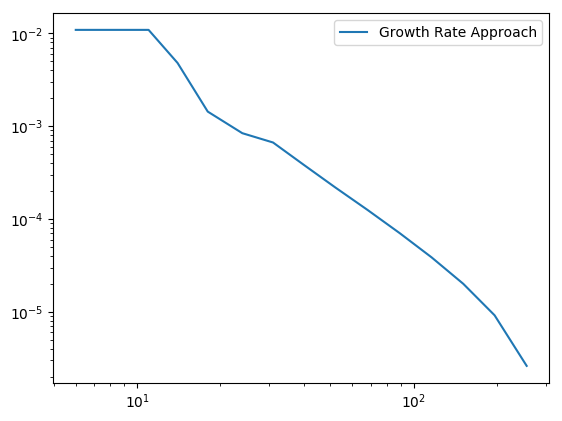

[0.0, 0.0, 0.0, 0.00609488, 0.00945744, 0.0100524, 0.0102258, 0.0105087, 0.0106735, 0.0107672, 0.0108223, 0.010854, 0.0108726, 0.0108835, 0.01089]


PyObject <matplotlib.legend.Legend object at 0x000000002EA13F60>

In [15]:
nValues = round.(Int64,logspace(0.8, 2.408,15))
bestValue_fd, bestKxIndex_Phil = findmax(growthRates_Phil_fd)
growthRates_forN_Phil_fd = zeros(length(nValues))
kxValue_Phil = 3.
for i =1:length(nValues)
    matrixSize = nValues[i]
    println("Working on $matrixSize")
    growthRates_fd, vectors, w_speeds, w_minSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxValue_Phil, S_Phillips, u_Phillips)
    growthRates_forN_Phil_fd[i] = growthRates_fd[1]
end
println(growthRates_forN_Phil_fd)
loglog(nValues, abs.(growthRates_forN_Phil_fd-bestValue_fd[1]), label="Growth Rate Approach")
legend(loc="upper right")

In [118]:

fig, axes = subplots(1,2)
ax = axes[1]
ax[:plot](kxs, growthRates_50, label="Growth Rates at N = 50")
ax = axes[2]
ax[:loglog](nValues, abs.(growthRates_forN-bestValue_fd[1]))
ax[:loglog](nValues, abs.(growthRates_forN_fd-bestValue_fd[1]))

LoadError: [91mUndefVarError: growthRates_50 not defined[39m

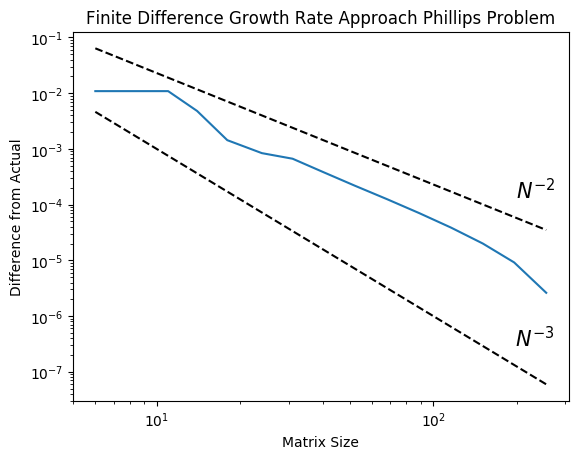

In [167]:
plot(nValues, abs.(growthRates_forN_Phil_fd-bestValue_fd[1]))
plot(nValues, 2.3*float(nValues).^-2, color="k", linestyle="dashed")
plot(nValues, float(nValues).^-3, color="k", linestyle="dashed")
xscale("log")
yscale("log")
title("Finite Difference Growth Rate Approach Phillips Problem")
xlabel("Matrix Size")
ylabel("Difference from Actual")
annotate(L"$N^{-2}$",
	xy=[1;0.5],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
annotate(L"$N^{-3}$",
	xy=[1;0.1],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
savefig("PhillipsProblemFDApproach.eps", format="eps", dpi=1000)